In [1]:
#from mpi4py import MPI 
import netket as nk
import netket.experimental as nkx
import nqs.BeH2_ptutorial as bpm
import pickle
import numpy as np
import math
from functools import reduce
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Preliminaries - check their data/inputs

The fermionic Hamiltonian in second quantization (with $M$ orbitals)

$$ H = \sum_{\alpha,\beta=1}^M t_{\alpha\beta}c^\dagger_\alpha c_\beta 
+ \frac{1}{2}\sum_{\alpha\beta=1}^M\sum_{\gamma\delta=1}^M u_{\alpha\beta\gamma\delta}c^\dagger_\alpha c^\dagger_\gamma c_\delta c_\beta$$

is mapped into a qubit Hamiltonian in the form (using a parity conserving transformation e.g Jordan Wigner)

$$ H = \sum_kc_kP_k $$

where $c_k$ are interaction coefficients and $P_k$ are elements of the $N$-qubit Pauli group $\mathcal{P}_N=\{\mathbb{1},X,Y,Z\}^{\otimes N}$.

The interaction coefficients and the Pauli operators are what we get from the `interaction.file` and the `pauli.file` respectively.

Specifics:
- Number of qubits: 6
- 2nd Q Fermionic Hamiltonian in basis: atomic STO-3G

In [2]:
# get data to build the qubit Hamiltonian for BeH2
pauli_list   = np.load('../data/tomography/BeH2/paulis.file',allow_pickle=True)
interactions = np.load('../data/tomography/BeH2/interactions.file',allow_pickle = True)
for k in range(10):
    print('Pauli:',pauli_list[k],' | Interaction: %.3E' % interactions[k])
print('...')

Pauli: IIIIII  | Interaction: -1.707E+01
Pauli: ZIIIII  | Interaction: 1.156E-01
Pauli: XXZIII  | Interaction: 7.270E-03
Pauli: YYIIII  | Interaction: 7.270E-03
Pauli: ZZIIII  | Interaction: 1.000E-01
Pauli: ZXXIII  | Interaction: -4.618E-03
Pauli: IYYIII  | Interaction: -4.618E-03
Pauli: IZZIII  | Interaction: -1.599E-01
Pauli: IIZIII  | Interaction: -3.908E-01
Pauli: IIIZII  | Interaction: 1.156E-01
...


In [3]:
type(interactions)

list

In [73]:
# Define some parameters + get paths to data

N = 6          # Number of qubits
ns = 100000    # Number of training samples
lr = 0.01      # Learning rate
M = 20000      # Number of samples for the negative CD phase
bs = 100     # Batch size
epochs = 600   # Epochs


samples_path = "../data/tomography/BeH2/train_samples.txt"
bases_path = "../data/tomography/BeH2/train_bases.txt"
pauli_path = "../data/tomography/BeH2/paulis.file"
interactions_path = "../data/tomography/BeH2/interactions.file"
ed_energy = float(np.loadtxt("../data/tomography/BeH2/energy.txt"))
psi0 = np.loadtxt("../data/tomography/BeH2/psi.txt")

In [76]:
# ground state -- obtained by diagonalizing the Hamiltonian
print(psi0)
print(psi0.shape)

[-5.81061279e-16  1.55898334e-17  2.60173055e-16 -6.34340264e-17
 -5.27084735e-18 -4.22405947e-16 -4.39571078e-16 -8.53024890e-17
 -1.40233185e-16  8.71311245e-03  1.62174211e-03  1.40012954e-16
 -5.64321033e-03  2.63953129e-16 -4.61694423e-16  1.87897356e-03
  7.95891039e-17  1.62174211e-03 -6.18030936e-02  5.94663742e-16
 -2.66801733e-03  3.70688077e-16  3.53824630e-16  4.75449726e-02
 -5.72155797e-17 -2.49914646e-16 -2.36595855e-16 -2.79809215e-02
  1.89599335e-15 -5.12492398e-16  4.19017623e-02 -1.15696469e-16
 -8.71589307e-16 -5.64321033e-03 -2.66801733e-03 -2.19399394e-15
  9.89989331e-01  1.09026373e-16  5.41641412e-15 -3.19908661e-03
  3.40740278e-16 -4.22707697e-16  1.22337899e-16 -1.58246406e-16
 -2.27298586e-16 -8.60540447e-18 -2.66637460e-16 -4.44007642e-16
  7.02191571e-17  3.04821532e-16  4.35256206e-16  4.19017623e-02
 -4.88407380e-15  1.15635900e-16 -7.44036686e-02 -2.19587293e-16
  7.98645496e-17  1.87897356e-03  4.75449726e-02  1.78048952e-16
 -3.19908661e-03  5.14521

In [77]:
# load the data

# Load the dataset
data = np.load('../Scripts/beh2_measurements_M128000new.npz', allow_pickle=True)

# Access the arrays
bitstring_array = data['bitstrings']  # Shape: (128000, 6) - floats
basis_strings = data['basis_strings']  # Shape: (128000,) - strings like 'XIYIZI'
basis_operators = data['basis_operators']  # Shape: (128000,) - LocalOperator objects
ground_state = data['ground_state']  # Shape: (64,) - ground state vector
statistics = data['statistics'].item()  # Dictionary with stats
pauli_strings = data['pauli_strings']  # Original Hamiltonian Pauli terms
coefficients = data['coefficients']  # Original Hamiltonian coefficients
n_qubits = data['n_qubits'].item()  # Number of qubits (6 for BeH2)

# Check what you loaded
print(f"Bitstrings shape: {bitstring_array.shape}")
print(f"Basis operators shape: {basis_operators.shape}")
print(f"Number of qubits: {n_qubits}")
print(f"\nFirst 3 samples:")
for i in range(3):
    print(f"  Bitstring: {bitstring_array[i]} | Basis: {basis_strings[i]}")

# Statistics
print(f"\nDataset statistics:")
print(f"  Total samples: {statistics['n_samples']:,}")
print(f"  Unique bases: {statistics['unique_bases']}")
print(f"  Expected unique bases: {statistics['expected_unique_bases']}")

Bitstrings shape: (128000, 6)
Basis operators shape: (128000,)
Number of qubits: 6

First 3 samples:
  Bitstring: [1. 0. 0. 1. 1. 1.] | Basis: ZZIIYY
  Bitstring: [1. 0. 0. 1. 0. 0.] | Basis: IIIIZZ
  Bitstring: [1. 0. 0. 1. 0. 0.] | Basis: ZIZIII

Dataset statistics:
  Total samples: 128,000
  Unique bases: 164
  Expected unique bases: 164


In [78]:
# build rbm + sampler + driver etc -- start with Hamiltonian first

# Hilbert space
hi = nk.hilbert.Qubit(N=6)
# NetKet Hamiltonian
hamiltonian = bpm.BuildHamiltonian(N,hi,pauli_path,interactions_path)

In [79]:
# Check the constructed H

# Get the Hamiltonian as a dense matrix
H_matrix = hamiltonian.to_dense()



print("\n=== HAMILTONIAN ANALYSIS ===")
print(f"Hamiltonian type: {type(hamiltonian)}")
print(f"Hamiltonian dtype: {hamiltonian.dtype}")

print(f"Hamiltonian shape: {H_matrix.shape}")
print(f"Is Hermitian? {np.allclose(H_matrix, H_matrix.conj().T)}")

# Try to compute energy on a random state
test_state = np.random.randn(2**N) + 1j * np.random.randn(2**N)
test_state = test_state / np.linalg.norm(test_state)

# Manual energy calculation
H_matrix = hamiltonian.to_dense()  # Get full matrix
test_energy = np.vdot(test_state, H_matrix @ test_state).real
print(f"Test energy on random state: {test_energy}")
print(f"ED ground state energy: {ed_energy}")

# Get eigenvalues + eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)
print(f"\nLowest 5 eigenvalues:")
print(eigenvalues[:5])
print(f"Highest 5 eigenvalues:")
print(eigenvalues[-5:])

## "" confirming that the ED energy they gave is actually the ground state
print(f"\nED ground state energy: {ed_energy}")
print(f"Hamiltonian ground state: {eigenvalues[0]}")

# Ground state we get from diagonalizing the H we built from the Pauli words and coefs
ground_state = eigenvectors[:, 0]
print(f"\nGround state eigenvector shape: {ground_state.shape}")

# get exact ground state and compare with the one they got:
print("Overlap between the gs calculated here and the one they got:",np.dot(ground_state,psi0))


=== HAMILTONIAN ANALYSIS ===
Hamiltonian type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Hamiltonian dtype: complex128
Hamiltonian shape: (64, 64)
Is Hermitian? True
Test energy on random state: -17.0292875794582
ED ground state energy: -19.038795049423

Lowest 5 eigenvalues:
[-19.03879505 -18.57708276 -18.53549258 -18.38773058 -18.38068849]
Highest 5 eigenvalues:
[-15.90826383 -15.64704217 -15.64704217 -15.06263444 -13.72257779]

ED ground state energy: -19.038795049423
Hamiltonian ground state: -19.038795049422998

Ground state eigenvector shape: (64,)
Overlap between the gs calculated here and the one they got: (1.0000000000000007+0j)


So we have:
- Hamiltonian of BeH2 constructed from Pauli words and coefs
- Ground state of this Hamiltonian from exact diagonalization, psi0
- Also have the ground state energy, ED_energy

In [80]:
# 2q |4>C|8>C

In [81]:
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

## A. The RBM

$$
\boxed{
\psi_\lambda(\boldsymbol{\sigma}) = \exp\left(\sum_{i=1}^{N} a_i \sigma_i\right) \prod_{j=1}^{M} 2\cosh\left( b_j + \sum_{i=1}^{N} W_{ij}\sigma_i \right)
}

$$


- A normalized state is $|\Psi\rangle = \sum_{\boldsymbol{\sigma}}\psi_\lambda(\boldsymbol{\sigma}) | \boldsymbol{\sigma}\rangle / \mathcal{N}$ with $\mathcal{N}=\sqrt{\sum_{\boldsymbol{\sigma}}|\psi_\lambda(\boldsymbol{\sigma})|^2}$.

In [85]:
# RBM wavefunction
ma = nk.models.RBM(alpha=3, param_dtype=complex)        # Complex-weights RBM, alpha=num_hidden/N


### A.1 Sampling - Metropolis Algorithm

draw samples $\boldsymbol{\sigma}$ from the probability distribution

$$
p(\boldsymbol{\sigma}) = \frac{|\psi_\lambda(\boldsymbol{\sigma})|^2}{\mathcal{Z}}
$$

- At each step, choose a visible spin index $i$ at random and propose to flip it:

$$
\sigma_i' = -\sigma_i, \qquad \boldsymbol{\sigma}' = (\sigma_1,\ldots,\sigma_i',\ldots,\sigma_N)
$$

- **Acceptance ratio:** The acceptance probability for this move is

$$
A(\boldsymbol{\sigma}\to\boldsymbol{\sigma}') = \min(1, R), \qquad R = \frac{|\psi_\lambda(\boldsymbol{\sigma}')|^2}{|\psi_\lambda(\boldsymbol{\sigma})|^2}
$$

- Explicitly,

$$
R = \exp(-4\mathrm{Re}[a_i\sigma_i]) \prod_{j=1}^M \frac{|\cosh(\theta_j - 2 W_{ij}\sigma_i)|^2}{|\cosh(\theta_j)|^2}
$$

In [86]:
# Sampler
sa = nk.sampler.MetropolisLocal(hilbert=hi)
sa


MetropolisSampler(
  hilbert = Qubit(N=6),
  rule = LocalRule(),
  n_chains = 16,
  sweep_size = 6,
  reset_chains = False,
  machine_power = 2,
  dtype = int8)

## B. Optimizer for Gradient Estimation

When SR is coupled with RMSprop the full update looks like:


$$
    \nabla_\lambda \langle H \rangle^{SR} = S^{-1} \cdot \nabla_\lambda \langle H \rangle

    \quad \text{(``Preconditioned gradient")}

$$ 



$$
    v_t = \beta \cdot v_{t-1} + (1-\beta) \cdot (\nabla_\lambda \langle H \rangle^{SR})^2 \quad \text{(RMSprop tracking)}
$$

$$ 
    \lambda_t = \lambda_{t-1} - \frac{\eta}{\sqrt{v_t + \epsilon} } \cdot \nabla_\lambda \langle H \rangle^{SR}  \quad \text{(RMSprop update)}
$$

In [87]:
# Optimizer + Stochastic Reconfiguration "preconditioner" -- down a few cells
op = nk.optimizer.RmsProp(learning_rate=0.01,beta=0.9,epscut = 1.0e-6)
sr = nk.optimizer.SR()

In [88]:
# define the variational state - specifiy the sampler and the model to sample from
vs = nk.vqs.MCState(
    sampler=sa,
    model=ma,
    n_samples=M, # cvhanged this to ns from M
    seed=42,
)

# let's see it now# Initialize with small random parameters
vs.init_parameters(seed=42)

#let's see it
vs

MCState(
  hilbert = Qubit(N=6),
  sampler = MetropolisSampler(rule = LocalRule(), n_chains = 16, sweep_size = 6, reset_chains = False, machine_power = 2, dtype = int8),
  n_samples = 20000,
  n_discard_per_chain = 5,
  sampler_state = MetropolisSamplerState(rng state=[113260412 727711444]),
  n_parameters = 132)

### B. Training Objective -- still adding detail 

KL-Divergence:
$$C_\lambda = \sum_b \sum_{\sigma^b} P(\sigma^b) \log \frac{P(\sigma^b)}{p_\lambda(\sigma^b)} \approx -\sum_b \sum_{\sigma^b} P(\sigma^b) \log p_\lambda(\sigma^b)$$

Approximated as:

$$\mathcal{L} = -\sum_{\sigma^b \in D} \log p_\lambda(\sigma^b)$$

Gradient of this objective with respect to parameters:
$$\nabla_\lambda \mathcal{L} = \left[\langle \Phi_\lambda^*(\sigma) \rangle_{p_\lambda(\sigma)} - \langle \langle \Phi_\lambda^*(\sigma) \rangle_{Q^{\sigma^b}_\lambda(\sigma)} \rangle_D\right]$$

where $ \Phi_\lambda^*(\sigma) $ is the same as equations 1-3 in appendix of HQC, except for the more nuanced definition of the `positive phase' term.

The gradients are estimated by Monte Carlo sampling, and the parameters are updated iteratively by the optimizer we defined above (RMSprop with SR) :

$$
\lambda \leftarrow \lambda - \eta \nabla_\lambda \mathcal{L}
$$

In [89]:
# # Experimental dataset??

# qst = nkx.QSR(training_data=training_dataset,
#               training_batch_size=bs,
#               optimizer=op,
#               variational_state=vs,
#               preconditioner=sr,
#               seed=42)

In [90]:
# # Suggestion from Filippo
# from netket.experimental.qsr import RawQuantumDataset
# training_data=(tr_samples,Us)
# training_dataset = RawQuantumDataset(training_data)

In [91]:
# build a driver to manage the optimisation loop
# Trains the rbm using the optimizer defined, then further down it's used to sample from the pdf to get mc samples
qst = nkx.QSR(training_data=(bitstring_array[:ns],basis_operators[:ns]),
              training_batch_size=bs,
              optimizer=op,
              variational_state=vs,
              preconditioner=sr,
              seed=42)

In [92]:
# Check a basis operator from your dataset
test_basis = qst._raw_dataset.bases[0]
print("Test basis operator:", test_basis)
print("Acting on:", test_basis.acting_on)

# It should show acting_on with actual qubit indices, NOT []

Test basis operator: LocalOperatorJax(dim=6, acting_on=[(0, 1, 2, 3, 4, 5)], constant=0j, dtype=complex128)
Acting on: [(0, 1, 2, 3, 4, 5)]


In [93]:
# Test get_conn
test_measurement = qst._raw_dataset.measurements[0]
sigma_p, mels = test_basis.get_conn(test_measurement)
print("Test measurement:", test_measurement)
print("Connected states:", sigma_p)
# sigma_p should equal test_measurement!

Test measurement: [1. 0. 0. 1. 1. 1.]
Connected states: [[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1.]]


In [94]:
sigma_p, mels = test_basis.get_conn(test_measurement)
print("Matrix elements:", mels)

Matrix elements: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]


In [95]:
# Can you print what basis string this corresponds to?
print("Basis string for this operator:", basis_strings[0])

Basis string for this operator: ZZIIYY


In [96]:
# Show the first operator's structure
print("Operator type:", type(test_basis))
print("Operator matrix shape:", test_basis.to_dense().shape if hasattr(test_basis, 'to_dense') else "N/A")

Operator type: <class 'netket.operator._local_operator.jax.LocalOperatorJax'>
Operator matrix shape: (64, 64)


In [97]:
qst

QSR(
  step_count = 0,
  state = MCState(hilbert = Qubit(N=6), sampler = MetropolisSampler(rule = LocalRule(), n_chains = 16, sweep_size = 6, reset_chains = False, machine_power = 2, dtype = int8), n_samples = 20000))

In [98]:
# object to log the details of training 
logger = nk.logging.RuntimeLog()

# B.1 Optimisation Loop

At each step of the optimisation loop, we estimate the expectation value of the Hamiltonian by drawing samples, $\sigma_j$, from the probability distribution $|\psi_\lambda(\boldsymbol{\sigma})|^2$ and computing:

$$
H_\lambda = \frac{1}{n_{\mathrm{MC}}}
\sum_{j=1}^{n_{\mathrm{MC}}}
\frac{\langle \sigma_j | \hat{H} | \psi_\lambda \rangle}{
      \langle \sigma_j | \psi_\lambda \rangle
}
$$


In [99]:
# # Training loop
fidelity = []
for ep in qst.iter(epochs+1, 10):
    # Get energy measurement
    obs = qst.estimate(hamiltonian) 
    # Compute overlap with exact states
    overlap = np.abs(np.vdot(qst.state.to_array(), psi0))
    fidelity.append(overlap**2)
    rbm_energy = obs.mean.real
    print('Epoch = %d   ' % ep,end='')
    print('Fidelity = %.6f   '% fidelity[-1],end='')
    print("<H> = %.8f" % rbm_energy,end=" | ")
    print("ED = %.8f" % ed_energy)

Epoch = 0   Fidelity = 0.014192   <H> = -16.90874215 | ED = -19.03879505
Epoch = 10   Fidelity = 0.012414   <H> = -16.87651194 | ED = -19.03879505
Epoch = 20   Fidelity = 0.004821   <H> = -16.80624929 | ED = -19.03879505
Epoch = 30   Fidelity = 0.000823   <H> = -16.79631333 | ED = -19.03879505
Epoch = 40   Fidelity = 0.000068   <H> = -16.81883727 | ED = -19.03879505
Epoch = 50   Fidelity = 0.000018   <H> = -16.83301127 | ED = -19.03879505
Epoch = 60   Fidelity = 0.000074   <H> = -16.82924670 | ED = -19.03879505
Epoch = 70   Fidelity = 0.000102   <H> = -16.84809500 | ED = -19.03879505
Epoch = 80   Fidelity = 0.000116   <H> = -16.87096074 | ED = -19.03879505
Epoch = 90   Fidelity = 0.000106   <H> = -16.87722085 | ED = -19.03879505
Epoch = 100   Fidelity = 0.000053   <H> = -16.88059602 | ED = -19.03879505
Epoch = 110   Fidelity = 0.000018   <H> = -16.88404374 | ED = -19.03879505
Epoch = 120   Fidelity = 0.000225   <H> = -16.98030490 | ED = -19.03879505
Epoch = 130   Fidelity = 0.001920   

In [100]:
test_basis = basis_operators[0]  # or qst._raw_dataset.bases[0]
test_measurement = bitstring_array[0]

print("Basis string:", basis_strings[0])
sigma_p, mels = test_basis.get_conn(test_measurement)
print("Test measurement:", test_measurement)
print("Connected states:\n", sigma_p)
print("Matrix elements:", mels)
print("Number of connected states:", len(sigma_p))

Basis string: ZZIIYY
Test measurement: [1. 0. 0. 1. 1. 1.]
Connected states:
 [[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1.]]
Matrix elements: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
Number of connected states: 4


In [101]:
# check that the driver is actually doing the correct estimation

# During training, after an epoch:
obs = qst.estimate(hamiltonian)
rbm_energy = obs.mean.real

# Also compute it manually:
psi_rbm = vs.to_array()  # Get RBM wavefunction
H_matrix = hamiltonian.to_dense()
manual_energy = np.vdot(psi_rbm, H_matrix @ psi_rbm).real / np.vdot(psi_rbm, psi_rbm).real

print(f"qst.estimate energy: {rbm_energy}")
print(f"Manual energy: {manual_energy}")
print(f"RBM norm: {np.linalg.norm(psi_rbm)}")

qst.estimate energy: -17.01012974540927
Manual energy: -16.866283882200847
RBM norm: 0.9999999999999999


In [102]:
# confirming that psi0 is indeed the ground state
np.vdot(psi0, H_matrix @ psi0).real / np.vdot(psi0, psi0).real

np.float64(-19.038795049422998)

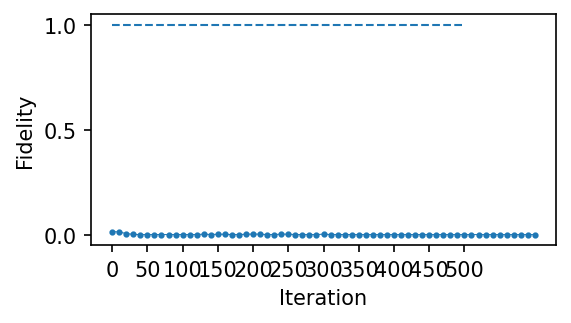

In [103]:
fig = plt.figure(1,figsize=(4,2), dpi=150, facecolor='w', edgecolor='k')

plt.plot(fidelity,linewidth=0.5,marker='o',markersize=2)
plt.xlabel("Iteration",fontsize=10)
plt.ylabel("Fidelity",fontsize=10)
plt.yticks([0.0,0.5,1.0],fontsize=10)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50],[0,50,100,150,200,250,300,350,400,450,500],fontsize=10)
plt.hlines(1.0,xmin=0,xmax = 50,linewidth=1.0,linestyle="--")

plt.show()